### Loading Important Libraries 

In [1]:
import pandas as pd 
import numpy as np 
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import KBinsDiscretizer , LabelEncoder
from scipy import stats
from sklearn.metrics import roc_auc_score
import lightgbm
from lightgbm import LGBMClassifier

### Loading Data

In [2]:
#Loading train data 
train_data = pd.read_csv("train.csv")
#Loading test data 
test_data =  pd.read_csv("test.csv")

In [3]:
#Numerical columns
num_cols = ['Age', 'Vintage', 'Avg_Account_Balance']
#Categorical columns
cat_cols = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active']
#Target
target = 'Is_Lead'

### Data Preprocessing 

Missing Value Imputation 

In [4]:
## Filling missing values with another level, treating them as a separate category
## "UA" = Unavailable
train_data = train_data.fillna("UA")
test_data = test_data.fillna("UA")

Outlier Removal

In [5]:
## Removing 'Avg Account Balance' in train data,
## Which are larger than max value of 'Avg Account Balance' in test data.

train_data = train_data[train_data['Avg_Account_Balance']<=max(test_data.Avg_Account_Balance)].reset_index(drop=True)

### Feature Extraction / Feature Engineering 

Numerical Features 

In [6]:
## Log Transforming 'Avg Account Balance'
train_data['Avg_Account_Balance_log'] = np.log(train_data['Avg_Account_Balance'])
test_data['Avg_Account_Balance_log'] = np.log(test_data['Avg_Account_Balance'])

In [7]:
## Boxcox transformation for 'Vintage' column
fitted_data, fitted_lambda = stats.boxcox(np.abs(train_data['Vintage']))
train_data['Vintage_box'] = fitted_data
fitted_data, fitted_lambda = stats.boxcox(np.abs(test_data['Vintage']))
test_data['Vintage_box'] = fitted_data

In [9]:
## Binning 'Age' 
bins = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
bins.fit(train_data['Age'].values.reshape(-1,1))
train_data['Age_quantiles'] = bins.transform(train_data['Age'].values.reshape(-1,1)).astype(int)
test_data['Age_quantiles'] = bins.transform(test_data['Age'].values.reshape(-1,1)).astype(int)

In [11]:
## Binning 'Avg Account Balance' 
bins = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
bins.fit(train_data['Vintage'].values.reshape(-1,1))
train_data['Vintage_quantiles'] = bins.transform(train_data['Vintage'].values.reshape(-1,1)).astype(int)
test_data['Vintage_quantiles'] = bins.transform(test_data['Vintage'].values.reshape(-1,1)).astype(int)

Categorical Features

In [12]:
# Label Encoding the categorical features 

## Custom fuction for label encoding 

def df_lbl_enc(df):
    for c in cat_cols:
        lbl = LabelEncoder()
        df[c] = lbl.fit_transform(df[c])
    return df

## Label Encoding Categorical Columns in train data 

train_data = df_lbl_enc(train_data)

## Label Encoding Categorical Columns in test data 

test_data = df_lbl_enc(test_data)

In [13]:
# Frequency Encoding the 'Region Code'.
## Train Data 
dic = train_data['Region_Code'].value_counts(normalize=True).to_dict()
train_data['Region_Code'] = train_data['Region_Code'].map(dic)
## Test Data
dic = test_data['Region_Code'].value_counts(normalize=True).to_dict()
test_data['Region_Code'] = test_data['Region_Code'].map(dic)

In [14]:
## New Categorical Columns After Feature Extraction 

new_cat_cols = [ 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active', 'Age_quantiles','Vintage_quantiles']

### Train/Test Split 

In [17]:
## Preparing Train data 
## Dropping few columns
X_train = train_data.drop(['ID', 'Gender','Is_Lead','Vintage', 'Avg_Account_Balance'], axis=1)
y_train = train_data[target].values
## Preparing Test data 
## Dropping few columns
ID = test_data['ID']
X_test = test_data.drop(['ID','Gender', 'Vintage', 'Avg_Account_Balance'], axis=1)

### Model Building 

In [18]:
LGB_model = LGBMClassifier(boosting_type= 'dart', 
                           num_leaves = 31,
                           objective = 'binary',
                           max_depth = 8,
                           num_iterations = 300,
                           class_weight='balanced',
                           min_data_in_leaf = 50,
                           learning_rate = 0.1)


LGB_model.fit(X_train,y_train,categorical_feature = new_cat_cols,verbose = 0)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


LGBMClassifier(boosting_type='dart', class_weight='balanced', max_depth=8,
               min_data_in_leaf=50, num_iterations=300, objective='binary')

### Prediction / Train Score 

In [19]:
#Predicting on train data 
train_pred = LGB_model.predict_proba(X_train)[:,1]
# Getting ROC_AUC Score 
Train_score_LGB = roc_auc_score(y_train,train_pred)
# Printing Score 
print(Train_score_LGB)

0.8802825893483177


### Feature Importance 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

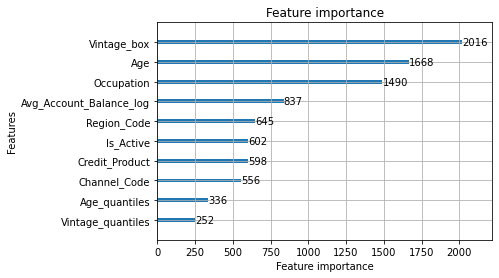

In [20]:
import lightgbm
lightgbm.plot_importance(LGB_model)

### Predicting on test data and final submission 

In [21]:
#Predicting on test data 
test_pred = LGB_model.predict_proba(X_test)[:,1]

In [22]:
# Predictions 
res = pd.DataFrame(test_pred)
ID = pd.DataFrame(ID)
res = res.rename(columns={res.columns[0]: 'Is_Lead'})
submission = pd.concat([ID,res], axis = 1)

submission.to_csv("LGBM_Final.csv",index = False)